# Complete Pipeline Notebook

This notebook runs the complete reasoning direction analysis pipeline from start to finish.

In [ ]:
import sys
sys.path.append('../pipeline')

import torch
import json
from pathlib import Path


import os

# Set HuggingFace cache directory to scratch to avoid home directory out of memory
os.environ['HF_HOME'] = '/scratch/gilbreth/sramishe'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/gilbreth/sramishe/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/gilbreth/sramishe/datasets'
# os.environ["TRANSFORMERS_OFFLINE"] = "1"
# os.environ["HF_HUB_OFFLINE"] = "1"



from model_loader import ModelLoader
from data_processor import DataProcessor
from direction_calculator import DirectionCalculator
from intervention import ActivationPatcher
from evaluator import ReasoningEvaluator


print(f"HuggingFace cache directory set to: {os.environ['HF_HOME']}")

/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


HuggingFace cache directory set to: /scratch/gilbreth/sramishe


In [2]:
print("HF_TOKEN set:", "HF_TOKEN" in os.environ)
print("HF_HOME:", os.environ.get("HF_HOME"))

HF_TOKEN set: True
HF_HOME: /scratch/gilbreth/sramishe


## Configuration

In [3]:
# Configuration parameters
CONFIG = {
    'rl_model_name': "Qwen/QwQ-32B",
    'distilled_model_name': "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
    'dataset_name': "HuggingFaceH4/MATH-500",
    'num_samples': 10,
    'strength_range': (-0.1, 0.1),
    'num_strengths': 2,
    'output_dir': '/scratch/gilbreth/sramishe/results_QwQ_R1/results',
    'max_new_tokens': 512
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  rl_model_name: Qwen/QwQ-32B
  distilled_model_name: deepseek-ai/DeepSeek-R1-Distill-Qwen-32B
  dataset_name: HuggingFaceH4/MATH-500
  num_samples: 10
  strength_range: (-0.1, 0.1)
  num_strengths: 2
  output_dir: /scratch/gilbreth/sramishe/results_QwQ_R1/results
  max_new_tokens: 512


## Step 1: Load Models

In [4]:
print("Step 1: Loading models...")

loader = ModelLoader(
    rl_model_name=CONFIG['rl_model_name'],
    distilled_model_name=CONFIG['distilled_model_name']
)

models = loader.load_models(torch_dtype=torch.float16)

rl_model = models['rl_model']
rl_tokenizer = models['rl_tokenizer']
distilled_model = models['distilled_model']
distilled_tokenizer = models['distilled_tokenizer']

model_info = loader.get_model_info()
print(f"✓ RL Model loaded: {model_info['rl_model']['num_layers']} layers")
print(f"✓ Distilled Model loaded: {model_info['distilled_model']['num_layers']} layers")

Step 1: Loading models...
Loading RL-trained model: Qwen/QwQ-32B


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 14/14 [00:41<00:00,  2.95s/it]


Loading distilled model: deepseek-ai/DeepSeek-R1-Distill-Qwen-32B


Loading checkpoint shards: 100%|██████████| 8/8 [04:39<00:00, 34.92s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


✓ RL Model loaded: 64 layers
✓ Distilled Model loaded: 64 layers


## Step 2: Load and Prepare Data

In [5]:
print("Step 2: Loading dataset...")

processor = DataProcessor(
    dataset_name=CONFIG['dataset_name'],
    include_toy_tasks=True
)

dataset = processor.load_dataset(max_samples=CONFIG['num_samples'])
toy_tasks = processor.get_toy_tasks()

all_examples = dataset + toy_tasks
prompts = processor.prepare_batch(all_examples[:CONFIG['num_samples']], rl_tokenizer)

print(f"✓ Loaded {len(all_examples)} examples")
print(f"✓ Prepared {len(prompts)} prompts")

Step 2: Loading dataset...
Loading dataset: HuggingFaceH4/MATH-500
✓ Loaded 14 examples
✓ Prepared 10 prompts


## Step 3: Calculate Reasoning Directions

In [6]:
print("Step 3: Calculating reasoning directions...")

calculator = DirectionCalculator()

# Determine layers to analyze
num_layers = model_info['rl_model']['num_layers']
layers_to_test = list(range(0, num_layers, 2))  # Sample every 2nd layer

print(f"Analyzing {len(layers_to_test)} layers: {layers_to_test}")

Step 3: Calculating reasoning directions...
Analyzing 32 layers: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62]


In [7]:
# Capture RL model activations
print("Capturing RL model activations...")
rl_activations = calculator.capture_activations(
    rl_model,
    rl_tokenizer,
    prompts[:5],  # Use subset for speed
    layers_to_test
)
print(f"✓ Captured activations for {len(rl_activations)} layers")

Capturing RL model activations...
✓ Captured activations for 32 layers


In [8]:
# Capture distilled model activations
print("Capturing distilled model activations...")
distilled_activations = calculator.capture_activations(
    distilled_model,
    distilled_tokenizer,
    prompts[:5],
    layers_to_test
)
print(f"✓ Captured activations for {len(distilled_activations)} layers")

Capturing distilled model activations...
✓ Captured activations for 32 layers


In [9]:
# Calculate directions
print("Computing direction vectors...")
directions = calculator.calculate_direction(
    rl_activations,
    distilled_activations,
    normalize_output=True
)
print(f"✓ Computed directions for {len(directions)} layers")

# Save directions
output_path = Path(CONFIG['output_dir'])
output_path.mkdir(parents=True, exist_ok=True)
directions_path = output_path / "reasoning_directions.pt"
calculator.save_directions(str(directions_path))
print(f"✓ Directions saved to {directions_path}")

Computing direction vectors...
✓ Computed directions for 32 layers
Directions saved to /scratch/gilbreth/sramishe/results_QwQ_R1/results/reasoning_directions.pt
✓ Directions saved to /scratch/gilbreth/sramishe/results_QwQ_R1/results/reasoning_directions.pt


## Step 4: Run Interventions

In [10]:
print("Step 4: Running interventions...")

patcher = ActivationPatcher(rl_model, directions)
test_prompt = prompts[0]

# Generate baseline
print("Generating baseline output...")
inputs = rl_tokenizer(test_prompt, return_tensors="pt").to(rl_model.device)
with torch.no_grad():
    baseline_output = rl_model.generate(**inputs, max_new_tokens=CONFIG['max_new_tokens'])
baseline_text = rl_tokenizer.decode(baseline_output[0], skip_special_tokens=True)
print(f"✓ Baseline generated ({len(baseline_output[0])} tokens)")

Step 4: Running interventions...
Generating baseline output...
✓ Baseline generated (569 tokens)


In [11]:
# Sweep interventions
print("Sweeping layers and strengths...")
intervention_results = patcher.sweep_layers_and_strengths(
    tokenizer=rl_tokenizer,
    prompt=test_prompt,
    layer_range=(min(layers_to_test), max(layers_to_test)),
    strength_range=CONFIG['strength_range'],
    num_strengths=CONFIG['num_strengths'],
    max_new_tokens=CONFIG['max_new_tokens']
)
print(f"✓ Completed {len(intervention_results)} intervention experiments")

Sweeping layers and strengths...
Applied interventions to layers: [0]


Applied interventions to layers: [0]
Applied interventions to layers: [2]
Applied interventions to layers: [2]
Applied interventions to layers: [4]
Applied interventions to layers: [4]
Applied interventions to layers: [6]
Applied interventions to layers: [6]
Applied interventions to layers: [8]
Applied interventions to layers: [8]
Applied interventions to layers: [10]
Applied interventions to layers: [10]
Applied interventions to layers: [12]
Applied interventions to layers: [12]
Applied interventions to layers: [14]
Applied interventions to layers: [14]
Applied interventions to layers: [16]
Applied interventions to layers: [16]
Applied interventions to layers: [18]
Applied interventions to layers: [18]
Applied interventions to layers: [20]
Applied interventions to layers: [20]
Applied interventions to layers: [22]
Applied interventions to layers: [22]
Applied interventions to layers: [24]
Applied interventions to layers: [24]
Applied interventions to layers: [26]
Applied interventions

## Step 5: Evaluate Results

In [12]:
print("Step 5: Evaluating results...")

evaluator = ReasoningEvaluator()

# Analyze layer sensitivity
sensitivity = evaluator.analyze_layer_sensitivity(intervention_results)
critical_layers = evaluator.identify_critical_layers(sensitivity)

print(f"✓ Layer sensitivity analyzed")
print(f"✓ Critical layers identified: {critical_layers}")

Step 5: Evaluating results...
✓ Layer sensitivity analyzed
✓ Critical layers identified: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62]


## Step 6: Generate Report and Save Results

In [13]:
print("Step 6: Generating report...")

# Generate evaluation report
report = evaluator.generate_report(
    intervention_results,
    output_file=str(output_path / "evaluation_report.txt")
)

# Save all results
results_data = {
    'config': CONFIG,
    'model_info': model_info,
    'directions_stats': calculator.compute_direction_stats(),
    'critical_layers': critical_layers,
    'layer_sensitivity': sensitivity,
    'intervention_results': intervention_results,
    'baseline_output': baseline_text
}

with open(output_path / "results.json", 'w') as f:
    json.dump(results_data, f, indent=2, default=str)

print(f"✓ Results saved to {output_path}")
print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)

Step 6: Generating report...
Report saved to /scratch/gilbreth/sramishe/results_QwQ_R1/results/evaluation_report.txt
✓ Results saved to /scratch/gilbreth/sramishe/results_QwQ_R1/results

PIPELINE COMPLETED SUCCESSFULLY!


## View Report

In [14]:
print(report)

REASONING DIRECTION EVALUATION REPORT

Summary Statistics:
Total experiments: 64
Layers tested: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62]
Strengths tested: [-0.1, 0.1]



## Quick Visualizations

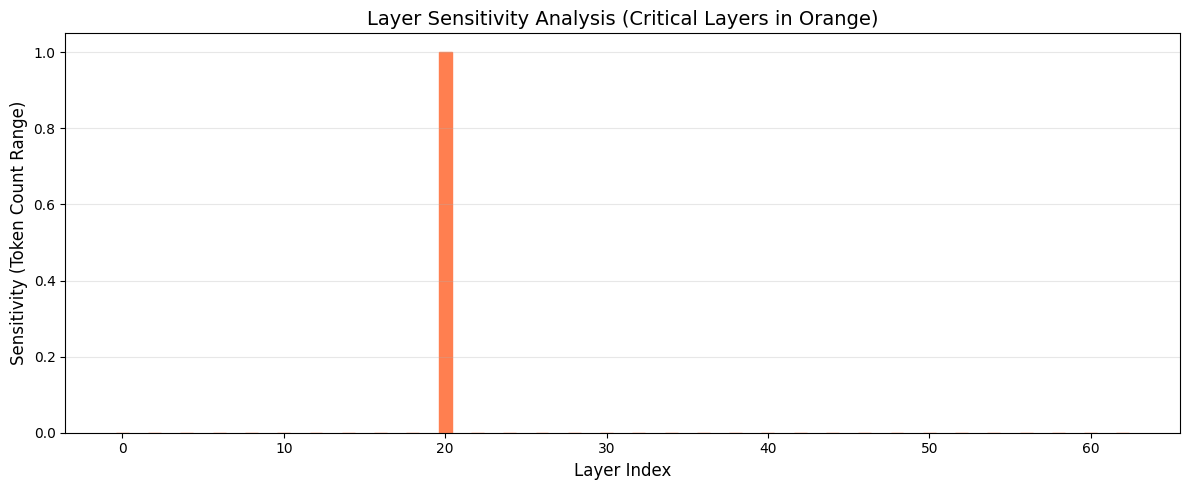

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize critical layers
layers = sorted(sensitivity.keys())
ranges = [sensitivity[layer]['range'] for layer in layers]

plt.figure(figsize=(12, 5))
bars = plt.bar(layers, ranges, color='steelblue', edgecolor='black')

# Highlight critical layers
for i, layer in enumerate(layers):
    if layer in critical_layers:
        bars[i].set_color('coral')

plt.xlabel('Layer Index', fontsize=12)
plt.ylabel('Sensitivity (Token Count Range)', fontsize=12)
plt.title('Layer Sensitivity Analysis (Critical Layers in Orange)', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()